In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import math
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
print('TensorFlow Version:', tf.__version__)

TensorFlow 1.x selected.
TensorFlow Version: 1.15.2


In [0]:
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
    x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    return (x_train, y_train), (x_test, y_test)

In [0]:
class model:
  def __init__(self, layer_dims):
    self.layer_dims = layer_dims
    self.L = len(layer_dims)
    self.hl = self.L-2
    self.n_x = layer_dims[0]
    self.n_y = layer_dims[-1]
    self.W = {}
    self.b = {}

  def info(self):
    print('------------------------------')
    print('Input Features:', self.n_x)
    print('Number of Classes:', self.n_y)
    for i in range(1, self.L-1):
        print('Units in Hidden Layer {}: {}'.format(i, self.layer_dims[i]))
    print('------------------------------')
  
  def init_params(self):
    for i in range(1, self.L):
      self.W['W'+str(i)] = tf.get_variable('W'+str(i),
                                       [self.layer_dims[i], self.layer_dims[i-1]],
                                       initializer = tf.contrib.layers.xavier_initializer())
      self.b['b'+str(i)] = tf.get_variable('b'+str(i),
                                                    [self.layer_dims[i], 1],
                                                    initializer = tf.zeros_initializer())
  
  def create_placeholders(self):
    x = tf.placeholder(dtype = tf.float32, shape = (self.n_x, None), name = "x")
    y = tf.placeholder(dtype = tf.float32, shape = (self.n_y, None), name = "y")
    return x, y

  def forward_pass_train(self, x, rate):
    Z = A = {}
    A[0] = x
    l = self.L-1
    for i in range(1, l):
      Z[i] = tf.add(tf.matmul(self.W['W'+str(i)], A[i-1]), self.b['b'+str(i)])
      relu = tf.nn.relu(Z[i])
      A[i] = tf.nn.dropout(relu, rate)
    Z[l] = tf.add(tf.matmul(self.W['W'+str(l)], A[l-1]), self.b['b'+str(l)])
    return Z[l]

  def forward_pass_test(self, x):
    Z = A = {}
    A[0] = x
    l = self.L-1
    for i in range(1, l):
      Z[i] = tf.add(tf.matmul(self.W['W'+str(i)], A[i-1]), self.b['b'+str(i)])
      A[i] = tf.nn.relu(Z[i])
    Z[l] = tf.add(tf.matmul(self.W['W'+str(l)], A[l-1]), self.b['b'+str(l)])
    return Z[l]

  def compute_cost(self, Z, y, lambd):
    logits = tf.transpose(Z)
    labels = tf.transpose(y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits,
                                                                  labels = labels))
    #for i in range(1, self.L):  
    regularizers = tf.nn.l2_loss(self.W['W1']) + tf.nn.l2_loss(self.W['W2']) + tf.nn.l2_loss(self.W['W3']) 
    cost = tf.reduce_mean(cost + lambd * regularizers)
    return cost

  def backward_pass(self, cost, learning_rate):
    return tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

In [0]:
class model(model):
  def random_mini_batches(self, x, y, mini_batch_size):   
    m = x.shape[1]
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_x = x[:, permutation]
    shuffled_y = y[:, permutation].reshape((y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_x = shuffled_x[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_y = shuffled_y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_x = shuffled_x[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_y = shuffled_y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    return mini_batches

In [0]:
class model(model):
  def train(self, x_train, y_train, x_test, y_test, epochs = 501,
            mini_batch_size = 128, learning_rate = 0.001,
            lambd = 0.01, keep_prob = 0.5, print_cost = True):
    ops.reset_default_graph()  
    costs = []
    lambd = tf.constant(lambd, name = "lambd")
    rate = tf.constant(1-keep_prob, name = "rate")
    x, y = self.create_placeholders()
    self.init_params()
    Z = self.forward_pass_test(x)
    cost = self.compute_cost(Z, y, lambd)
    optimizer = self.backward_pass(cost, learning_rate)
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
      sess.run(init)

      for epoch in range(epochs):
        epoch_cost = 0.
        m = x_train.shape[1]    #Number of examples
        num_minibatches = m//mini_batch_size
        mini_batches = self.random_mini_batches(x_train, y_train,
                                           mini_batch_size)
        for mini_batch in mini_batches:
          (x_minibatch, y_minibatch) = mini_batch
          _, minibatch_cost = sess.run([optimizer, cost], feed_dict = 
                                       {x: x_minibatch, y: y_minibatch})
          epoch_cost += minibatch_cost/mini_batch_size

        if print_cost == True and epoch % 100 == 0:
          print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        if print_cost == True and epoch % 5 == 0:
          costs.append(epoch_cost)

      plt.plot(np.squeeze(costs))
      plt.ylabel('cost')
      plt.xlabel('iterations (per fives)')
      plt.title("Learning rate =" + str(learning_rate))
      plt.show()


      #predictions = self.forward_pass_test(x)
      print("The model has been trained.")
      correct_prediction_train = tf.equal(tf.argmax(Z), tf.argmax(y))
      accuracy = tf.reduce_mean(tf.cast(correct_prediction_train, "float"))
      print("Train Accuracy: {:.3f}".format(accuracy.eval({x: x_train, y: y_train})))
      #correct_prediction_test = tf.equal(tf.argmax(predictions), tf.argmax(y))
      #test_accuracy = tf.reduce_mean(tf.cast(correct_prediction_test, "float"))
      print("Test Accuracy: {:.3f}".format(accuracy.eval({x: x_test, y: y_test})))

  def predict(self, x):
    Z = self.forward_pass_test(x)
    return tf.argmax(tf.nn.softmax(Z), axis = 1)

In [6]:
(x_train, y_train), (x_test, y_test) = load_data()
model = model([784, 512, 256, 128, 10])     
# First and last index above, represents the input and output layer dimensions respectively. 
# Rest are hidden layer dimensions. Any number of hidden layers can be added. Just make sure
# to make changes in the calculations of 'regularizers' in compute_cost function.
model.info()

------------------------------
Input Features: 784
Number of Classes: 10
Units in Hidden Layer 1: 512
Units in Hidden Layer 2: 256
Units in Hidden Layer 3: 128
------------------------------


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Cost after epoch 0: 5.099655
Cost after epoch 100: 0.674437
Cost after epoch 200: 0.622337
Cost after epoch 300: 0.595217
Cost after epoch 400: 0.587128
Cost after epoch 500: 0.591092


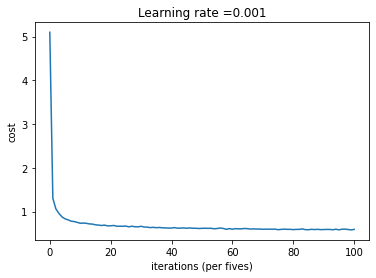

The model has been trained.
Train Accuracy: 0.975
Test Accuracy: 0.966


In [0]:
model.train(x_train.T, y_train.T, x_test.T, y_test.T)